In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys

### Functions required to parse the 'cfg.log' file from the experiments

In [2]:
def parse_config_log_with_final(filename):
    result = {}
    train_loss = []
    train_acc = []
    test_acc = []
    test_loss = []
    train_round_time = []
    test_round_time = []
    successfully_upload_clients_count = []
    loss_threshold = []
    loss_threshold_dict = {}
    loss_low = []
    loss_low_dict = {}
    loss_high = []
    loss_high_dict = {}
    deadlines = []
    deadlines_dict = {}
    deadlines_high = []
    deadlines_high_dict = {}
    deadlines_low = []
    deadlines_low_dict = {}
    loss_threshold_ratio = []
    loss_threshold_ratio_dict = {}
    deadline_ratio = []
    deadline_ratio_dict = {}
    current_round_loss = []
    round_duration_time = []
    
    f = open(filename)

    f_lines = f.readlines()
    
    current_round = 0
    
    is_final_appeared = False
    
    for line in f_lines:
        tmp = line.split(' ')
        if '=====================' in tmp and 'Round' in tmp and 'of' in tmp:
            current_round += 1
        if 'average' in tmp and 'acc:' in tmp:
            train_acc.append(float(tmp[tmp.index('average')+2][:-1]))
            train_loss.append(float(tmp[tmp.index('average')+5][:-1]))
        elif 'test_accuracy:' in tmp:
            test_acc.append(float(tmp[tmp.index('test_accuracy:')+1][:-1]))
        elif 'test_loss:' in tmp:
            test_loss.append(float(tmp[tmp.index('test_loss:')+1][:-1]))
        elif 'current' in tmp and 'time:' in tmp:
            train_round_time.append(float(tmp[tmp.index('time:')+1].split('\t')[0]))
            if len(train_round_time)%5 == 0:
                test_round_time.append(float(tmp[tmp.index('time:')+1].split('\t')[0]))
        elif 'upload' in tmp and 'successfully\n' in tmp:
            if tmp.index('successfully\n') - tmp.index('upload') == 1:
                successfully_upload_clients_count.append(float(tmp[tmp.index('upload')-4]))
            else:
                continue
        elif 'round' in tmp and 'failed,' in tmp and 'global' in tmp:
            train_acc.append(train_acc[-1])
            train_loss.append(train_loss[-1])
        elif 'loss_threshold' in tmp and 'loss_high' in tmp and 'loss_low' in tmp:
            loss_threshold.append(float(tmp[tmp.index('loss_threshold')+1][:-1]))
            loss_threshold_dict[current_round] = (float(tmp[tmp.index('loss_threshold')+1][:-1]))
            loss_low.append(float(tmp[tmp.index('loss_low')+1][:-1]))
            loss_low_dict[current_round] = (float(tmp[tmp.index('loss_low')+1][:-1]))
            loss_high.append(float(tmp[tmp.index('loss_high')+1][:-1]))
            loss_high_dict[current_round] = (float(tmp[tmp.index('loss_high')+1][:-1]))
        elif 'deadline' in tmp and 'ratio' in tmp and 'loss_threshold' in tmp:
            deadline_ratio.append(float(tmp[tmp.index('deadline')+2][:-1]))
            deadline_ratio_dict[current_round] = (float(tmp[tmp.index('deadline')+2][:-1]))
            loss_threshold_ratio.append(float(tmp[tmp.index('loss_threshold')+2].strip()))
            loss_threshold_ratio_dict[current_round] = (float(tmp[tmp.index('loss_threshold')+2].strip()))
        elif 'this' in tmp and 'round' in tmp and 'deadline' in tmp and'ratio' not in tmp:
            deadlines.append(float(tmp[tmp.index('deadline')+1][:-1]))
            deadlines_dict[current_round] = (float(tmp[tmp.index('deadline')+1][:-1]))
        elif 'deadline_low' in tmp and 'deadline_high' in tmp:
            deadlines_low.append(float(tmp[tmp.index('deadline_low')+1][:-1]))
            deadlines_low_dict[current_round] = (float(tmp[tmp.index('deadline_low')+1][:-1]))
            deadlines_high.append(float(tmp[tmp.index('deadline_high')+1][:-1]))
            deadlines_high_dict[current_round] = (float(tmp[tmp.index('deadline_high')+1][:-1]))
        elif 'loss_threshold_ratio' in tmp:
            loss_threshold_ratio.append(float(tmp[tmp.index('loss_threshold_ratio')+1].strip()))
        elif 'current_round_loss:' in tmp:
            current_round_loss.append(float(tmp[tmp.index('current_round_loss:')+1].strip()))
        elif 'stage' in tmp and 'simulation' in tmp:
            round_duration_time.append(float(tmp[tmp.index('time:')+1].strip()))
        elif 'FINAL' in tmp:
            is_final_appeared = True
    
    if is_final_appeared and len(test_round_time) != len(test_acc):
        test_round_time.append(train_round_time[-1])
    
    result['train_loss'] = train_loss
    result['train_acc'] = train_acc
    result['test_loss'] = test_loss
    result['test_acc'] = test_acc
    result['train_round_time'] = train_round_time
    result['test_round_time'] = test_round_time
    result['successfully_upload_clients_count'] = successfully_upload_clients_count
    result['loss_threshold'] = loss_threshold
    result['loss_threshold_dict'] = loss_threshold_dict
    result['loss_low'] = loss_low
    result['loss_low_dict'] = loss_low_dict
    result['loss_high'] = loss_high
    result['loss_high_dict'] = loss_high_dict
    result['deadlines_low'] = deadlines_low
    result['deadlines_low_dict'] = deadlines_low_dict
    result['deadlines_high'] = deadlines_high
    result['deadlines_high_dict'] = deadlines_high_dict
    result['loss_threshold_ratio'] = loss_threshold_ratio
    result['loss_threshold_ratio_dict'] = loss_threshold_ratio_dict
    result['deadlines'] = deadlines
    result['deadlines_dict'] = deadlines_dict
    result['deadline_ratio'] = deadline_ratio
    result['deadline_ratio_dict'] = deadline_ratio_dict
    result['current_round_loss'] = current_round_loss
    result['round_duration_time'] = round_duration_time
    
    return result

In [3]:
def measure_time(log_dict, objective, what_to_check):
    i = -1
    for i, acc in enumerate(log_dict[what_to_check]):
        if acc >= objective:
            return log_dict['test_round_time'][i]
    return sys.maxsize

In [4]:
def measure_final_acc(log_dict, what_to_check, global_final_time):
    for i in range(len(log_dict['test_round_time'])):
        if log_dict['test_round_time'][i] >= global_final_time:
            return log_dict[what_to_check][i-1]
    return log_dict[what_to_check][-1]

In [5]:
def perfect_plot(ax, xarr, yarr, label):
    if len(xarr) != len(yarr):
        ax.plot(xarr[:-1], yarr, label = label)
    else:
        ax.plot(xarr, yarr, label = label)

### Experimental Result

In [6]:
fedavg_1T = parse_config_log_with_final('../models/configs/femnist/femnist_fedavg_1T.cfg.log')
fedavg_2T = parse_config_log_with_final('../models/configs/femnist/femnist_fedavg_2T.cfg.log')
fedavg_SPC = parse_config_log_with_final('../models/configs/femnist/femnist_fedavg_SPC.cfg.log')
fedavg_WFA = parse_config_log_with_final('../models/configs/femnist/femnist_fedavg_WFA.cfg.log')
fedprox_1T = parse_config_log_with_final('../models/configs/femnist/femnist_fedprox_mu_0_0_1T.cfg.log')
fedprox_2T = parse_config_log_with_final('../models/configs/femnist/femnist_fedprox_mu_0_0_2T.cfg.log')
sampleselection_baseline = parse_config_log_with_final('../models/configs/femnist/femnist_sampleselection_baseline.cfg.log')
fedbalancer = parse_config_log_with_final('../models/configs/femnist/femnist_fedbalancer.cfg.log')

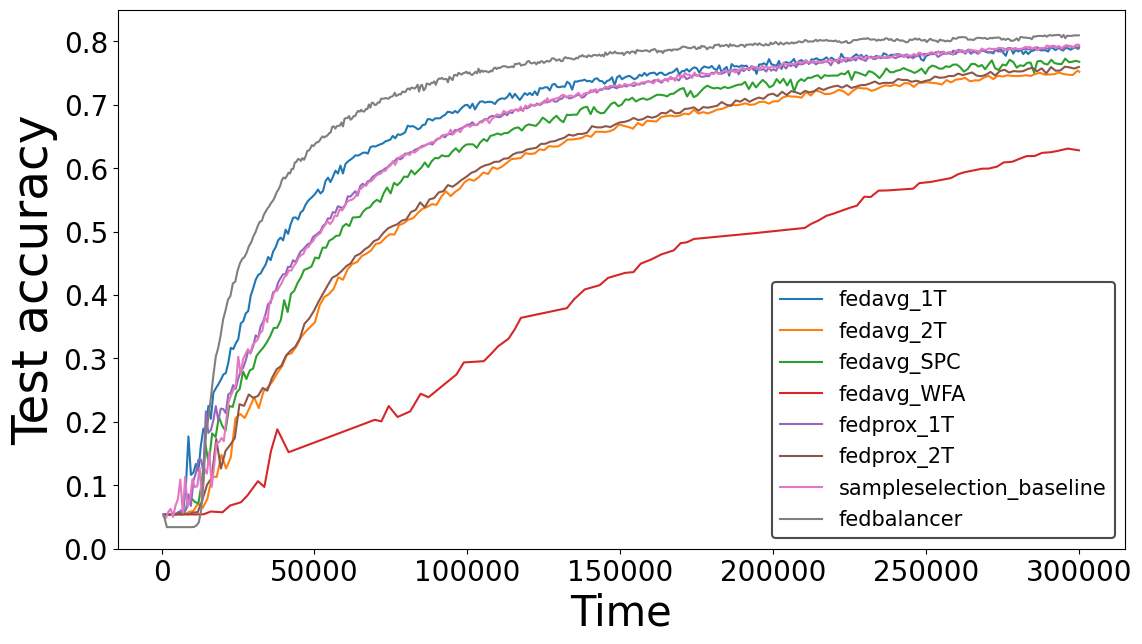

In [8]:
fig, ax = plt.subplots(figsize=(13, 7))

ax.set_xlabel('Time', fontsize=30)
ax.set_ylabel('Test accuracy', fontsize=35)
plt.tick_params(labelsize=20) #27
ax.set_title('', fontsize=30)
plt.ylim([0,0.85])

perfect_plot(ax, fedavg_1T['test_round_time'], fedavg_1T['test_acc'], label='fedavg_1T')
perfect_plot(ax, fedavg_2T['test_round_time'], fedavg_2T['test_acc'], label='fedavg_2T')
perfect_plot(ax, fedavg_SPC['test_round_time'], fedavg_SPC['test_acc'], label='fedavg_SPC')
perfect_plot(ax, fedavg_WFA['test_round_time'], fedavg_WFA['test_acc'], label='fedavg_WFA')

perfect_plot(ax, fedprox_1T['test_round_time'], fedprox_1T['test_acc'], label='fedprox_1T')
perfect_plot(ax, fedprox_2T['test_round_time'], fedprox_2T['test_acc'], label='fedprox_2T')

perfect_plot(ax, sampleselection_baseline['test_round_time'], sampleselection_baseline['test_acc'], label='sampleselection_baseline')

perfect_plot(ax, fedbalancer['test_round_time'], fedbalancer['test_acc'], label='fedbalancer')

plt.legend(loc=4, fontsize=15, edgecolor='black',framealpha=0.7).get_frame().set_linewidth(1.5) #25